## Title: EDA and Feature Engineering
Author: Yiran Jing

Date: 11-07-2019


**DataSet description**
- OneStreamGolfData.csv
- weatherdata.csv
- Our target is **Amount** 
- Item_Id: **region+product+retailer**: we have **3478** items



In [326]:
import boto3
import pandas as pd
import pyspark
from sagemaker import get_execution_role
import seaborn as sns
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, skew
import statsmodels.api as sm
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

#### Load dataset

In [327]:
golf_data = 's3://taysolsdev/datasets/GolfDataforecast/OneStreamGolfData.csv'
golf_data = pd.read_csv(golf_data, encoding = "ISO-8859-1")

In [329]:
weather_data = 's3://taysolsdev/datasets/GolfDataforecast/weatherdata.csv'
weather_data = pd.read_csv(weather_data, encoding = "ISO-8859-1")

## Clean Data
- convert column name to all lower cases
- strip the leading space for columns
#### Rename columns
- rename 'UD3' to 'region', same as the column name in weather data.
- rename 'time' to 'month', same as the column name in weather data.
- rename 'UD2' to 'product'
- rename 'UD4' to 'retailer'
- remove space in the column entry 
#### Delete unnecessary columns
- delete the columns if nan values only
- delete the columns if no missing value and just one value within that column, since this kind of column give us no useful info for modelling

#### Create target column
Create new column caller target, which is produc+ region+ retailer

In [330]:
# initial columns' name
golf_data.columns

Index(['Cube', ' Entity', ' Parent', ' Cons', ' Scenario', ' Time', ' View',
       ' Account', ' Flow', ' Origin', ' IC', ' UD1', ' UD2', ' UD3', ' UD4',
       ' UD5', ' UD6', ' UD7', ' UD8', ' Amount', ' HasData', ' Annotation',
       ' Assumptions', ' AuditComment', ' Footnote', ' VarianceExplanation'],
      dtype='object')

In [331]:
# initial columns' name
weather_data.columns

Index(['Region', 'Month', 'High ', 'Low', 'RainFall', 'Snowfall',
       'Daylight Hours'],
      dtype='object')

In [332]:
# change column name to all lower cases
golf_data = golf_data.rename(str.lower, axis='columns')
weather_data = weather_data.rename(str.lower, axis='columns')

In [333]:
for column_name in golf_data.columns:
    clean_column = column_name.replace(" ","") # strip the leading space for columns
    golf_data[clean_column] = golf_data[column_name]
    del golf_data[column_name] # delete the old column

In [334]:
# rename 'UD3' to 'region', same as the column name in weather data.
golf_data = golf_data.rename(index=str, columns={"ud3": "region"})
# rename 'time' to 'month', same as the column name in weather data
golf_data = golf_data.rename(index=str, columns={"time": "month"})
# rename 'UD2' to 'product'
golf_data = golf_data.rename(index=str, columns={"ud2": "product"})
# rename 'UD4' to 'retailer'
golf_data = golf_data.rename(index=str, columns={"ud4": "retailer"})
# remove space in the column entry
golf_data['retailer'] = golf_data['retailer'].str.replace(' ', '')

### Remove unnecessary columns
- delete the columns if nan values only
- delete the columns if no missing value and just one value within that column, since this kind of column give us no useful info for modelling

In [335]:
print ("\nUnique values :  \n", golf_data.nunique())


Unique values :  
 entity                     2
parent                     0
cons                       1
scenario                   2
month                     24
view                       1
account                    2
flow                       1
origin                     1
ic                         1
ud1                        1
product                   19
region                    36
retailer                  18
ud5                        1
ud6                        1
ud7                        1
ud8                        1
amount                 14826
hasdata                    1
annotation                 0
assumptions                0
auditcomment               0
footnote                   0
varianceexplanation        0
dtype: int64


In [336]:
golf_data['parent'].unique()

array([nan])

From the list above, we can see there are nan values only in annotation, assumptions, auditcomment, footnote, varianceexplanation and parent, Thus we delete these columns.

In [337]:
# delete the column since no information in it
del golf_data['annotation']
del golf_data['assumptions']
del golf_data['auditcomment']
del golf_data['footnote']
del golf_data['varianceexplanation']
del golf_data['parent']

In [338]:
# check if still missing value here
golf_data.isnull().sum()

entity      0
cons        0
scenario    0
month       0
view        0
account     0
flow        0
origin      0
ic          0
ud1         0
product     0
region      0
retailer    0
ud5         0
ud6         0
ud7         0
ud8         0
amount      0
hasdata     0
dtype: int64

From list above, we can see no missing value

In [339]:
golf_data['hasdata'].unique()

array(['Yes'], dtype=object)

In [265]:
# delete the columns if no missing value and just one value within that column
# since this kind of column give us no useful info for modelling
del golf_data['cons']
del golf_data['view']
del golf_data['flow']
del golf_data['origin']
del golf_data['ic']
del golf_data['ud1']
del golf_data['ud5']
del golf_data['ud6']
del golf_data['ud7']
del golf_data['ud8']
del golf_data['hasdata']

From the cell result below, we can see we entity, scenario and account are **binary variable**.

In [266]:
for column in golf_data:
    print(column)
    print(golf_data[column].unique())
    print("----------------")

entity
['Houston Heights' 'South Houston']
----------------
scenario
['Actual' 'BudgetV1']
----------------
month
['2010M1' '2010M2' '2010M3' '2010M4' '2010M5' '2010M6' '2010M7' '2010M8'
 '2010M9' '2010M10' '2010M11' '2010M12' '2011M1' '2011M2' '2011M3'
 '2011M4' '2011M5' '2011M6' '2011M7' '2011M8' '2011M9' '2011M10' '2011M11'
 '2011M12']
----------------
account
['2000_100' '2000_200']
----------------
product
['Mach5' 'Elite' 'Launcher' 'Mach10' 'Choker' 'Fat Boy' 'Hybrid SL'
 'Hybrid XF' 'Ice Man' 'Iron SL' 'Iron XF' 'Soft Touch' 'Thunder'
 'Ultimate XL' 'Wedge LT' 'Wedge XF' 'Wedges SL' 'Hybrid LT' 'Iron LT']
----------------
region
['Japan' 'SA' 'Midwest' 'Northeast' 'West' 'Europe' 'None' 'Southeast'
 'Canada' 'Southwest' 'Other NA' 'Mexico' 'Australia' 'Middle East'
 'South Korea' 'Other Asia' 'California' 'Florida' 'Georgia' 'Illinois'
 'Michigan' 'Nevada' 'Ohio' 'Oregon' 'Other Midwest' 'Other Southeast'
 'Other West' 'South Carolina' 'Connecticut' 'New Jersey' 'New York'
 'Ot

### Create new column called target, which is produc+ region+ retailer

In [267]:
golf_data['target'] = golf_data['product'] +"_"+ golf_data['region']+"_"+golf_data['retailer']
#del golf_data['product']
#del golf_data['region']
#del golf_data['retailer']

In [268]:
weather_data.head(2)

,region,month,high,low,rainfall,snowfall,daylight hours
0,Midwest,2010M1,2,-11,11,178,10
1,Midwest,2010M2,4,-9,15,226,11


## EDA

From the cell below, we can see we have 36 regions in main dataset, but weather data only contain 28 regions.

In [269]:
print("number of regions in galf dataset(our main dataset): {}".format(len(golf_data['region'].unique())))
print("number of regions in weather dataset(the dataset we want to join): {}".format(len(weather_data['region'].unique())))
      

number of regions in galf dataset(our main dataset): 36
number of regions in weather dataset(the dataset we want to join): 28


From the cell below, we can see we two datasets have the same length of time series data. Thus we can use the full weather dataset to help forecast the golf data. 

2 years data

In [270]:
print("month in golf data: ")
print(golf_data['month'].unique())
print("month in weather data: ")
print(weather_data['month'].unique())

month in golf data: 
['2010M1' '2010M2' '2010M3' '2010M4' '2010M5' '2010M6' '2010M7' '2010M8'
 '2010M9' '2010M10' '2010M11' '2010M12' '2011M1' '2011M2' '2011M3'
 '2011M4' '2011M5' '2011M6' '2011M7' '2011M8' '2011M9' '2011M10' '2011M11'
 '2011M12']
month in weather data: 
['2010M1' '2010M2' '2010M3' '2010M4' '2010M5' '2010M6' '2010M7' '2010M8'
 '2010M9' '2010M10' '2010M11' '2010M12' '2011M1' '2011M2' '2011M3'
 '2011M4' '2011M5' '2011M6' '2011M7' '2011M8' '2011M9' '2011M10' '2011M11'
 '2011M12']


In [271]:
final_trans = golf_data[['month', 'amount', 'target']]

In [272]:
target_list = golf_data['target'].unique()
print("the number of product for different regin and retailer is {}.".format(len(target_list)))

the number of product for different regin and retailer is 3478.


In [273]:
final_trans['month'] = final_trans['month'].str.replace('M10', '10')
final_trans['month'] = final_trans['month'].str.replace('M11', '11')
final_trans['month'] = final_trans['month'].str.replace('M12', '12')
final_trans['month'] = final_trans['month'].str.replace('M1', '01')
final_trans['month'] = final_trans['month'].str.replace('M2', '02')
final_trans['month'] = final_trans['month'].str.replace('M3', '03')
final_trans['month'] = final_trans['month'].str.replace('M4', '04')
final_trans['month'] = final_trans['month'].str.replace('M5', '05')
final_trans['month'] = final_trans['month'].str.replace('M6', '06')
final_trans['month'] = final_trans['month'].str.replace('M7', '07')
final_trans['month'] = final_trans['month'].str.replace('M8', '08')
final_trans['month'] = final_trans['month'].str.replace('M9', '09')

In [277]:
final_trans["month"][:len(final_trans)] =  pd.to_datetime(final_trans.month[:len(final_trans)], 
                                                          yearfirst = True, format='%Y%m')

final_trans = final_trans.sort_values(by="month")
# set month to index
final_trans.index = pd.DatetimeIndex(final_trans.month)
del final_trans["month"]

### Testing Assumptions of model: augmented Dickey fuller test

First part of classical time series model is that we require **stationarity** of the time series. We use the augmented Dickey fuller test. 

Recall that the null hypothesis is that we don't have a stationary time series, so a rejection suggests stationarity of the data. In other world, if p_value <0.01, we can say we have stationary data

from the result below, 3031 products are non-stationary, just 447 products are stationary.

In [300]:
from statsmodels.tsa.stattools import adfuller

products = final_trans.target.unique()
products_stationary = {} # collect stationary data: key is the name or product, value is p_value
products_nonstationary = {} # collect non-stationary data 


"""
Run ADF test on each product and check test.
"""
for prod in products:
    prod_df = final_trans[final_trans.target == prod]
    p_value = adfuller(prod_df['amount'])[1]
    if p_value <0.01:  # we do at the 1% comcident level.
        products_stationary[prod] = p_value
    else:
        products_nonstationary[prod] = p_value 
    #print("P-value for {} is {:.5f}".format(prod, adfuller(prod_df['amount'])[1]))
    

In [303]:
print("There are {} products with stationary data".format(len(products_stationary)))
print("There are {} products with non-stationary data".format(len(products_nonstationary)))


There are 447 products with stationary data
There are 3031 products with non-stationary data


### Plot original data if they are stationary

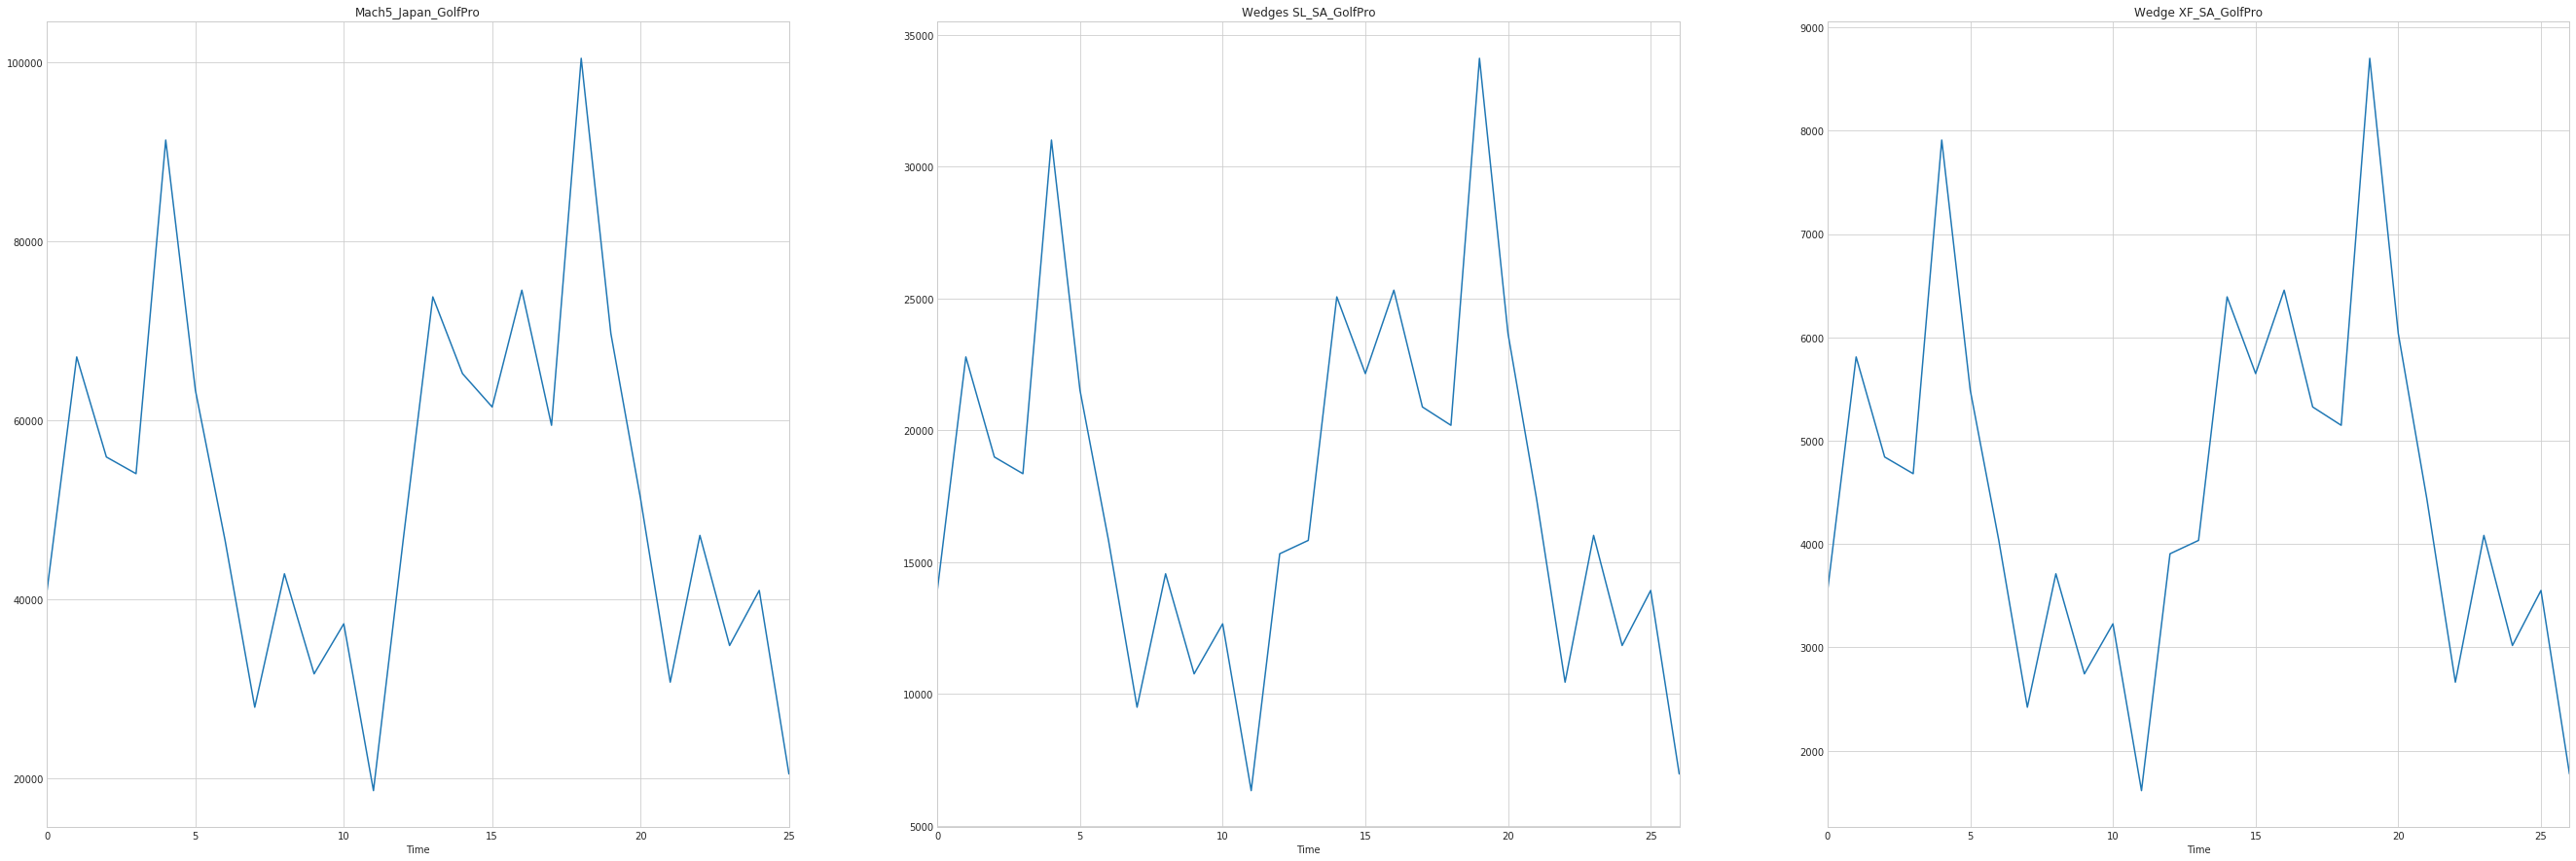

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

stationary_products = list(products_stationary.keys())

"""
Plot original data if they are stationary.
"""
#fig, axes = plt.subplots(nrows=1, ncols=len(golf_data['region'].unique()))
fig, axes = plt.subplots(nrows=1, ncols=3)

plt.subplot(1,3,1)
prod_df = final_trans[final_trans.target == stationary_products[0]]
sns.tsplot(prod_df['amount'])
plt.title(stationary_products[0])
plt.xlabel("Time")

plt.subplot(1,3,2)
prod_df = final_trans[final_trans.target == stationary_products[1]]
sns.tsplot(prod_df['amount'])
plt.title(stationary_products[1])
plt.xlabel("Time")

plt.subplot(1,3,3)
prod_df = final_trans[final_trans.target == stationary_products[2]]
sns.tsplot(prod_df['amount'])
plt.title(stationary_products[2])
plt.xlabel("Time")

# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

### Plot original data if they are not stationary

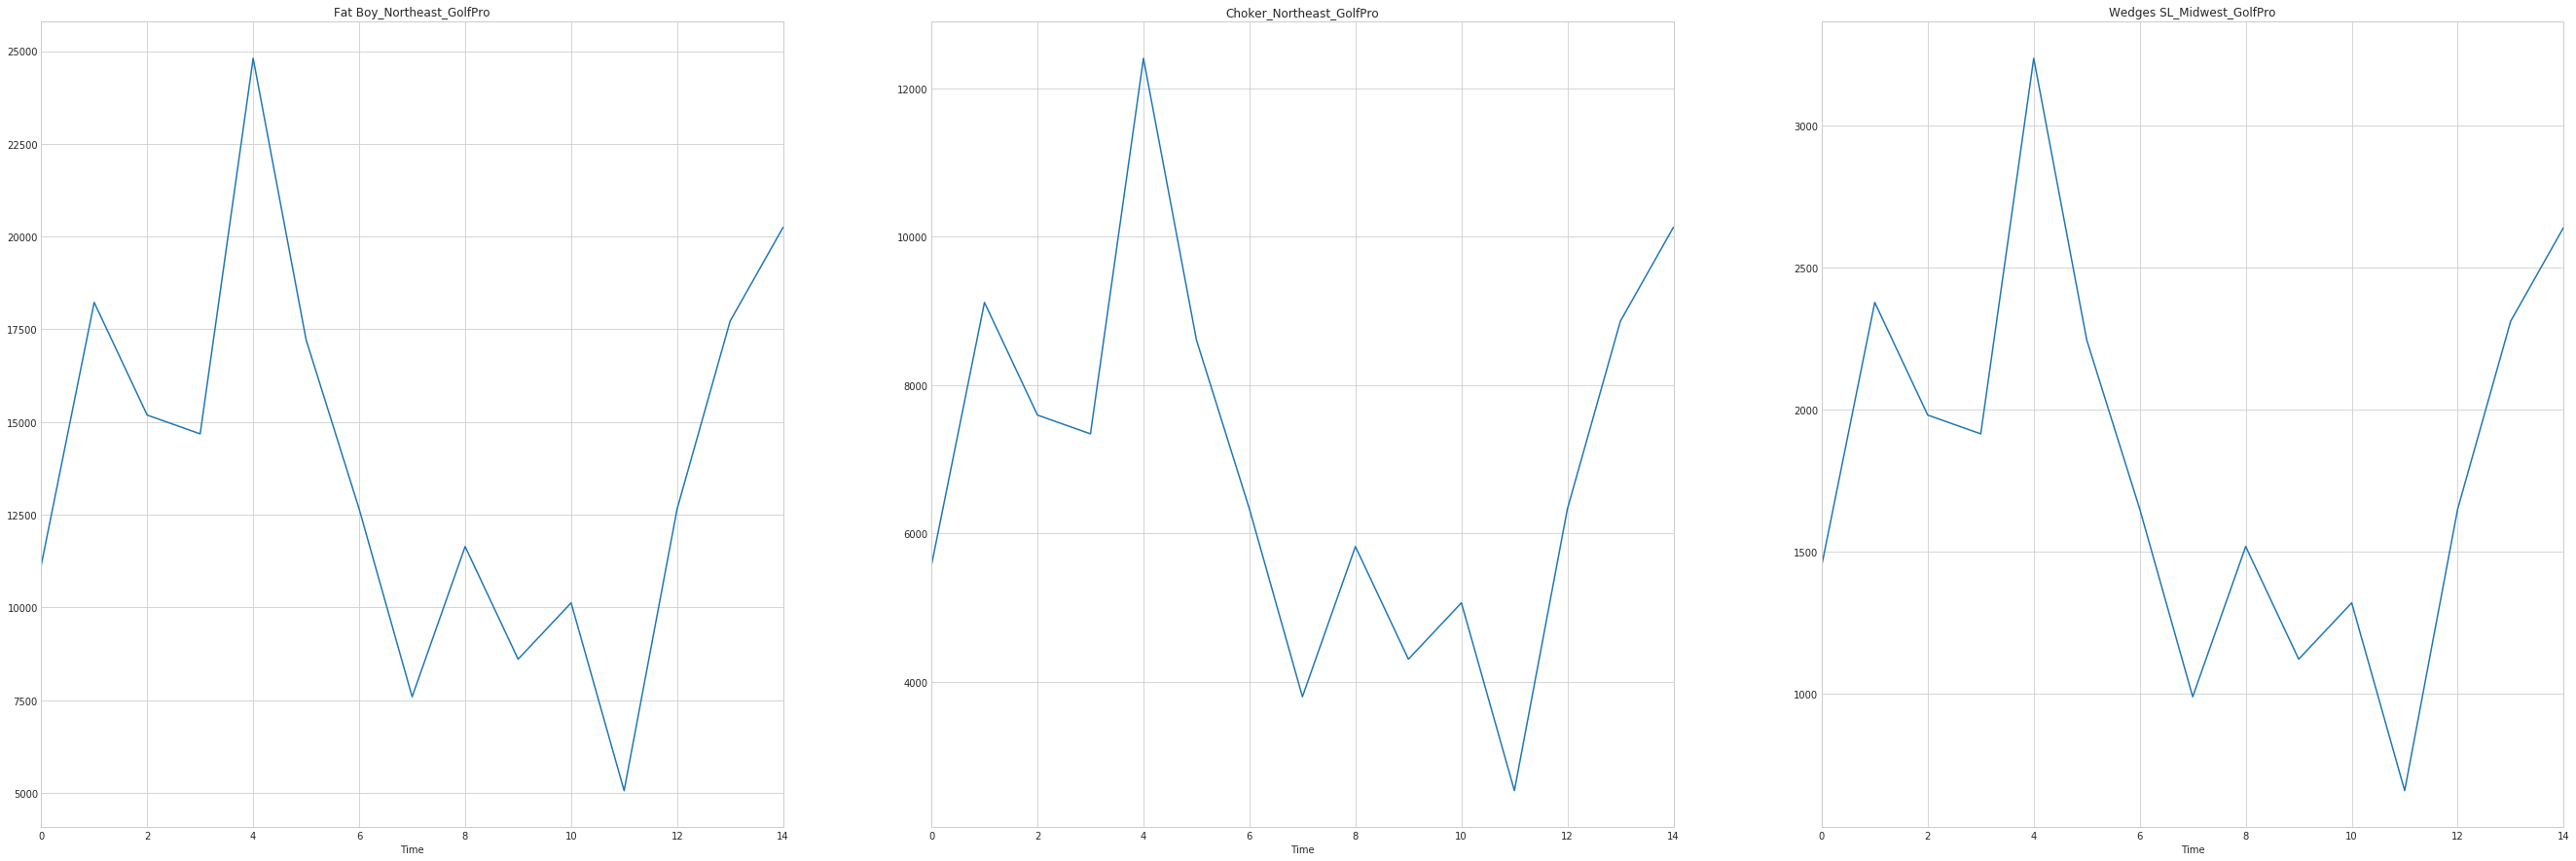

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

nonstationary_products = list(products_nonstationary.keys())

"""
Plot original data if they are stationary.
"""
#fig, axes = plt.subplots(nrows=1, ncols=len(golf_data['region'].unique()))
fig, axes = plt.subplots(nrows=1, ncols=3)

plt.subplot(1,3,1)
prod_df = final_trans[final_trans.target == nonstationary_products[0]]
sns.tsplot(prod_df['amount'])
plt.title(nonstationary_products[0])
plt.xlabel("Time")

plt.subplot(1,3,2)
prod_df = final_trans[final_trans.target == nonstationary_products[1]]
sns.tsplot(prod_df['amount'])
plt.title(nonstationary_products[1])
plt.xlabel("Time")

plt.subplot(1,3,3)
prod_df = final_trans[final_trans.target == nonstationary_products[2]]
sns.tsplot(prod_df['amount'])
plt.title(nonstationary_products[2])
plt.xlabel("Time")

# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

In [342]:
prod_df

,amount,target
month,,
2010-01-01,1452.739,Wedges SL_Midwest_GolfPro
2010-02-01,2377.210,Wedges SL_Midwest_GolfPro
2010-03-01,1981.008,Wedges SL_Midwest_GolfPro
2010-04-01,1914.974,Wedges SL_Midwest_GolfPro
2010-05-01,3235.646,Wedges SL_Midwest_GolfPro
2010-06-01,2245.142,Wedges SL_Midwest_GolfPro
2010-07-01,1650.840,Wedges SL_Midwest_GolfPro
2010-08-01,990.504,Wedges SL_Midwest_GolfPro
2010-09-01,1518.773,Wedges SL_Midwest_GolfPro


### Time decomposition

## Create useful one-dimensional Dataset 
Since input dataset for amazon forecasts need **one-dimensional**,i.e. only three columns in dataset: 
1. **timepoint**
2. **observations'value**: such as demand, sales, amount, also can be categorical dataset
3. **Item_id**: region in our case
4. **No header**